In [1]:
import datetime
print(f"last edit: {datetime.datetime.now()}")

last edit: 2025-08-13 07:59:35.009117


In [2]:
# Download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-08-13 07:59:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-08-13 07:59:35 (69.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

In [4]:
!nvidia-smi

Wed Aug 13 07:59:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Download data (food vision)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-08-13 07:59:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  41.3MB/s    in 39s     

2025-08-13 08:00:18 (40.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [7]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food

In [17]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE,
                                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [18]:
# Create checkoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [20]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")

In [21]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)


In [22]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps= int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.6536 - loss: 1.3886 - val_accuracy: 0.5400 - val_loss: 1.7770
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.6546 - loss: 1.3962 - val_accuracy: 0.5426 - val_loss: 1.7699
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.6638 - loss: 1.3840 - val_accuracy: 0.5440 - val_loss: 1.7637
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.6603 - loss: 1.3678 - val_accuracy: 0.5458 - val_loss: 1.7585
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.6686 - loss: 1.3664 - val_accuracy: 0.5474 - val_loss: 1.7534


In [26]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.5685 - loss: 1.6599


[1.5771214962005615, 0.5860198140144348]

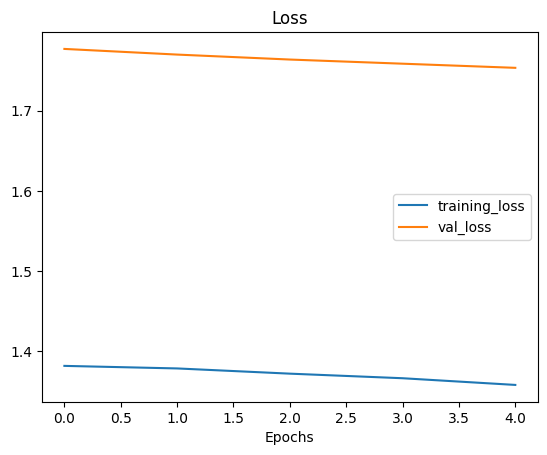

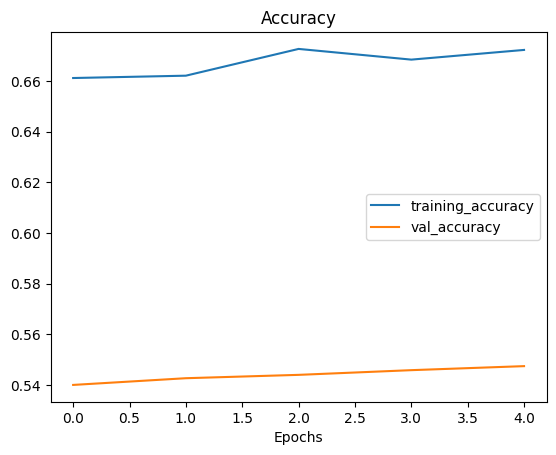

In [27]:
plot_loss_curves(history_all_classes_10_percent)

In [28]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [29]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [30]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [31]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [32]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 162ms/step - accuracy: 0.6216 - loss: 1.5090 - val_accuracy: 0.5628 - val_loss: 1.7061
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.6759 - loss: 1.3033 - val_accuracy: 0.5689 - val_loss: 1.6578
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.6917 - loss: 1.2237 - val_accuracy: 0.5794 - val_loss: 1.6156
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 34s 142ms/step - accuracy: 0.7087 - loss: 1.1587 - val_accuracy: 0.5840 - val_loss: 1.5884
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.7229 - loss: 1.0933 - val_accuracy: 0.5877 - val_loss: 1.5794
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 315ms/step - accuracy: 0.7388 - loss: 1.0519 - val_accuracy: 0.5903 - val_loss: 1.5608


In [33]:
results_all_10_classes_fine_tune = model.evaluate(test_data)
results_all_10_classes_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.6015 - loss: 1.5061


[1.417833685874939, 0.6207128763198853]